In [62]:
import hopsworks
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

from sklearn.ensemble import RandomForestClassifier

In [65]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/210070
Connected. Call `.close()` to terminate connection gracefully.


In [66]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
sp500_fg = fs.get_feature_group(name="sp500", version=2)
query = sp500_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="sp500",
                                  version=2,
                                  description="Read from sp500 dataset",
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/210070/fs/209989/fv/sp500/version/2


In [68]:
#Fetching the data from hopsworks and ordering it by date_copy column
df_sp500 = feature_view.get_batch_data()
df_sp500 = df_sp500.sort_values(by='date_copy')
df_sp500 = df_sp500.reset_index(drop=True)
#df_sp500 = df_sp500.reset_index()
df_sp500

Finished: Reading data from Hopsworks, using ArrowFlight (1.79s) 


,open,high,low,close,volume,date_copy
0,353.399994,359.690002,351.980011,359.690002,162070000,1990-01-02 05:00:00+00:00
1,359.690002,360.589996,357.890015,358.760010,192330000,1990-01-03 05:00:00+00:00
2,358.760010,358.760010,352.890015,355.670013,177000000,1990-01-04 05:00:00+00:00
3,355.670013,355.670013,351.350006,352.200012,158530000,1990-01-05 05:00:00+00:00
4,352.200012,354.239990,350.540009,353.790009,140110000,1990-01-08 05:00:00+00:00
...,...,...,...,...,...,...
8564,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,2023-12-29 05:00:00+00:00
8565,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,2024-01-02 05:00:00+00:00
8566,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,2024-01-03 05:00:00+00:00
8567,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,2024-01-04 05:00:00+00:00


In [71]:
df_sp500.index

RangeIndex(start=0, stop=8569, step=1)

In [74]:
df_sp500["tomorrow"] = df_sp500["close"].shift(-1)
df_sp500["target"] = (df_sp500["tomorrow"] > df_sp500["close"]).astype(int)

In [75]:
df_sp500

,open,high,low,close,volume,date_copy,tomorrow,target
0,353.399994,359.690002,351.980011,359.690002,162070000,1990-01-02 05:00:00+00:00,358.760010,0
1,359.690002,360.589996,357.890015,358.760010,192330000,1990-01-03 05:00:00+00:00,355.670013,0
2,358.760010,358.760010,352.890015,355.670013,177000000,1990-01-04 05:00:00+00:00,352.200012,0
3,355.670013,355.670013,351.350006,352.200012,158530000,1990-01-05 05:00:00+00:00,353.790009,1
4,352.200012,354.239990,350.540009,353.790009,140110000,1990-01-08 05:00:00+00:00,349.619995,0
...,...,...,...,...,...,...,...,...
8564,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,2023-12-29 05:00:00+00:00,4742.830078,0
8565,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,2024-01-02 05:00:00+00:00,4704.810059,0
8566,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,2024-01-03 05:00:00+00:00,4688.680176,0
8567,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,2024-01-04 05:00:00+00:00,4697.240234,1


In [76]:
#Creating a model and testing with the existing features
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = df_sp500[:-100]
test = df_sp500[-100:]

predictors = ["close", "volume", "open", "high", "low"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [77]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index, name = "predictions")
precision_score(test["target"], preds)

0.55

<Axes: xlabel='date_copy'>

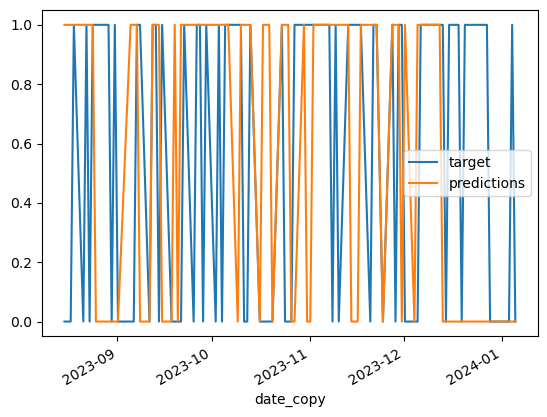

In [78]:
combined = pd.concat([test["target"], preds], axis=1)

# Assuming "Date" is the column containing datetime information
combined.index = pd.to_datetime(test["date_copy"])
combined.plot(y=["target", "predictions"])

In [79]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [80]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [81]:
predictions = backtest(df_sp500, model, predictors)

In [82]:
predictions["Predictions"].value_counts()

Predictions
0    3473
1    2596
Name: count, dtype: int64

In [83]:
precision_score(predictions["target"], predictions["Predictions"])

0.5288906009244992

In [84]:
predictions["target"].value_counts() / predictions.shape[0]

target
1    0.534355
0    0.465645
Name: count, dtype: float64

In [85]:
df_sp500.info

<bound method DataFrame.info of              open         high          low        close      volume  \
0      353.399994   359.690002   351.980011   359.690002   162070000   
1      359.690002   360.589996   357.890015   358.760010   192330000   
2      358.760010   358.760010   352.890015   355.670013   177000000   
3      355.670013   355.670013   351.350006   352.200012   158530000   
4      352.200012   354.239990   350.540009   353.790009   140110000   
...           ...          ...          ...          ...         ...   
8564  4782.879883  4788.430176  4751.990234  4769.830078  3126060000   
8565  4745.200195  4754.330078  4722.669922  4742.830078  3743050000   
8566  4725.069824  4729.290039  4699.709961  4704.810059  3950760000   
8567  4697.419922  4726.779785  4687.529785  4688.680176  3715480000   
8568  4690.569824  4721.490234  4682.109863  4697.240234  3844370000   

                     date_copy     tomorrow  target  
0    1990-01-02 05:00:00+00:00   358.760010      

In [86]:
df_sp500

,open,high,low,close,volume,date_copy,tomorrow,target
0,353.399994,359.690002,351.980011,359.690002,162070000,1990-01-02 05:00:00+00:00,358.760010,0
1,359.690002,360.589996,357.890015,358.760010,192330000,1990-01-03 05:00:00+00:00,355.670013,0
2,358.760010,358.760010,352.890015,355.670013,177000000,1990-01-04 05:00:00+00:00,352.200012,0
3,355.670013,355.670013,351.350006,352.200012,158530000,1990-01-05 05:00:00+00:00,353.790009,1
4,352.200012,354.239990,350.540009,353.790009,140110000,1990-01-08 05:00:00+00:00,349.619995,0
...,...,...,...,...,...,...,...,...
8564,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,2023-12-29 05:00:00+00:00,4742.830078,0
8565,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,2024-01-02 05:00:00+00:00,4704.810059,0
8566,4725.069824,4729.290039,4699.709961,4704.810059,3950760000,2024-01-03 05:00:00+00:00,4688.680176,0
8567,4697.419922,4726.779785,4687.529785,4688.680176,3715480000,2024-01-04 05:00:00+00:00,4697.240234,1


In [87]:
horizons = [2,5,60,250,1000]
date_copy=df_sp500['date_copy'].copy()
df_sp500 = df_sp500.drop(columns=['date_copy'])

for horizon in horizons:
    rolling_averages = df_sp500.rolling(horizon).mean()
    
    ratio_column = f"close_ratio_{horizon}"
    df_sp500[ratio_column] = df_sp500["close"] / rolling_averages["close"]
    
    trend_column = f"trend_{horizon}"
    df_sp500[trend_column] = df_sp500.shift(1).rolling(horizon).sum()["target"]
    
    #new_predictors+= [ratio_column, trend_column]

df_sp500['date_copy']=date_copy.copy()


new_predictors = ['close_ratio_2','trend_2','close_ratio_5','trend_5','close_ratio_60','trend_60','close_ratio_250','trend_250','close_ratio_1000','trend_1000','close','volume','open','high','low']

In [88]:
# #Drop rows with missing values (NaN) in any column except the "Tomorrow" column

df_sp500 = df_sp500.dropna(subset=df_sp500.columns[df_sp500.columns != "tomorrow"])

In [89]:
df_sp500.columns

Index(['open', 'high', 'low', 'close', 'volume', 'tomorrow', 'target',
       'close_ratio_2', 'trend_2', 'close_ratio_5', 'trend_5',
       'close_ratio_60', 'trend_60', 'close_ratio_250', 'trend_250',
       'close_ratio_1000', 'trend_1000', 'date_copy'],
      dtype='object')

In [39]:
new_predictors

['close_ratio_2',
 'trend_2',
 'close_ratio_5',
 'trend_5',
 'close_ratio_60',
 'trend_60',
 'close_ratio_250',
 'trend_250',
 'close_ratio_1000',
 'trend_1000',
 'close',
 'volume',
 'open',
 'high',
 'low']

In [90]:
model2 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [91]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [92]:
predictions = backtest(df_sp500, model2, new_predictors)

In [93]:
predictions["predictions"].value_counts()

predictions
0.0    4572
1.0     497
Name: count, dtype: int64

In [94]:
precision_score_metrics=precision_score(predictions["target"], predictions["predictions"])
precision_score_metrics

0.5513078470824949

In [95]:
predictions["target"].value_counts() / predictions.shape[0]

target
1    0.544092
0    0.455908
Name: count, dtype: float64

In [96]:
predictions

,target,predictions
3500,0,0.0
3501,0,1.0
3502,1,1.0
3503,0,0.0
3504,1,1.0
...,...,...
8564,0,0.0
8565,0,0.0
8566,0,0.0
8567,1,0.0


In [98]:
#Hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Assuming X and y are your features and labels
# X, y = ...
X = df_sp500[new_predictors][:-100]
y = df_sp500["target"][:-100]
X_test = df_sp500[new_predictors][-100:]
y_test = df_sp500["target"][-100:]
#================================================================================================

# Define the parameter grid to search through
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 50]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)  # Adjust the number of splits as needed

# Initialize GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=tscv, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X, y)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions using cross_val_score
cv_scores = cross_val_score(best_rf_model, X, y, cv=tscv, scoring='accuracy')

# Evaluate the model
print("Accuracy on Cross-Validation Set:", cv_scores.mean())

Accuracy on Cross-Validation Set: 0.4963161419959813


In [99]:
# Assuming X_test is your test set features
# X_test, y_test = ...

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)


Accuracy on Test Set: 0.52


In [100]:
precision_score(y_test, y_pred)

0.5689655172413793

In [101]:
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# import pandas as pd

# # Assuming X and y are your features and labels
# # X, y = ...
# X = df_sp500[predictors][:-100]
# y = df_sp500["target"][:-100]
# X_test = df_sp500[predictors][-100:]
# y_test = df_sp500["target"][-100:]
# #================================================================================================

# # Define the parameter grid to search through
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Initialize the Random Forest Classifier
# rf_classifier = RandomForestClassifier()

# # Initialize TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=3)  # Adjust the number of splits as needed

# # Initialize GridSearchCV with TimeSeriesSplit
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=tscv, scoring='accuracy')

# # Fit the model to the data
# grid_search.fit(X, y)

# # Get the best model
# best_rf_model = grid_search.best_estimator_

# # Make predictions using cross_val_score
# cv_scores = cross_val_score(best_rf_model, X, y, cv=tscv, scoring='accuracy')

# # Evaluate the model
# print("Accuracy on Cross-Validation Set:", cv_scores.mean())

In [102]:
# # Assuming X_test is your test set features
# # X_test, y_test = ...

# # Make predictions on the test set
# y_pred = best_rf_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy on Test Set:", accuracy)


In [103]:
#Trying Backtesting after hyperparameter tuning

predictions2 = backtest(df_sp500, best_rf_model, new_predictors)

In [104]:
predictions2["predictions"].value_counts()

predictions
0.0    4760
1.0     309
Name: count, dtype: int64

In [105]:
precision_score_metrics2 = precision_score(predictions2["target"], predictions2["predictions"])
precision_score_metrics2

0.5857605177993528

In [106]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'sp500_model' directory will be saved to the model registry. Create the dir, first.
model_dir="sp500_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save our rf_model(random forest) to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(best_rf_model, model_dir + "/sp500_model.pkl")   

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(df_sp500[new_predictors])
output_schema = Schema(df_sp500["target"])
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
sp500_model = mr.python.create_model(
    name="sp500_model",
    version=2,
    metrics={"precision_score" : precision_score_metrics2},
    model_schema=model_schema,
    description="sp500 Stock Direction Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
sp500_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading model files (0 dirs, 0 files):  17%|▋   | 1/6 [00:00<00:01,  3.13it/s]
Uploading: 0.000%|                         | 0/1360041 elapsed<00:00 remaining<?
Uploading: 77.099%|██████████▊   | 1048576/1360041 elapsed<00:01 remaining<00:00
Uploading: 100.000%|█████████████| 1360041/1360041 elapsed<00:02 remaining<00:00
Uploading input_example and model_schema:  33%|█  | 2/6 [00:03<00:07,  1.76s/it]
Uploading: 0.000%|                            | 0/1257 elapsed<00:00 remaining<?
Uploading: 100.000%|███████████████████| 1257/1257 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████████████████| 6/6 [00:10<00:00,  1.73s/it]

Model created, explore it at https://c.app.hopsworks.ai:443/p/210070/models/sp500_model/2


Model(name: 'sp500_model', version: 2)